In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2

import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'pre-processing/data_sharpen/train/'
test_dir = 'pre-processing/data_sharpen/test/'

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.1.6
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
output_classes = 7
batch_size = 8

img_height, img_width = 600, 450
input_shape = (img_height, img_width, 3)
epochs = 50

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

pre-processing/data_sharpen/train/ 0
pre-processing/data_sharpen/train/AKIEC 34704
pre-processing/data_sharpen/train/BCC 19092
pre-processing/data_sharpen/train/BKL 13100
pre-processing/data_sharpen/train/DF 16608
pre-processing/data_sharpen/train/MEL 13232
pre-processing/data_sharpen/train/NV 19900
pre-processing/data_sharpen/train/VASC 6976
******************************
pre-processing/data_sharpen/test/ 0
pre-processing/data_sharpen/test/AKIEC 74
pre-processing/data_sharpen/test/BCC 139
pre-processing/data_sharpen/test/BKL 284
pre-processing/data_sharpen/test/DF 30
pre-processing/data_sharpen/test/MEL 312
pre-processing/data_sharpen/test/NV 1730
pre-processing/data_sharpen/test/VASC 33


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 92709 images belonging to 7 classes.
Found 30903 images belonging to 7 classes.
Found 2602 images belonging to 7 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 92709
nb_validation_samples: 30903

predict_size_train: 11589
predict_size_validation: 3863
nb_test_samples: 2602
predict_size_test: 326

 num_classes: 7


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
model = Sequential()
# Conv Layer 1
model.add(layers.SeparableConv2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Dropout(0.25))

# Conv Layer 2
model.add(layers.SeparableConv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Dropout(0.25))

# Conv Layer 3
model.add(layers.SeparableConv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Dropout(0.25))

# Flatten the data for upcoming dense layer
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(output_classes, activation=tf.nn.softmax))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 596, 446, 32)      203       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 298, 223, 32)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 294, 219, 64)      2912      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 147, 109, 64)      0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 143, 105, 128)     9920      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 71, 52, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 472576)            0         
__________

In [11]:
# adam_opt = Adam(lr=0.0001, decay=1e-5)
adam_opt=Adam(lr=0.0001, beta_1=0.6, beta_2=0.995, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
11588/11588 [==============================] - 5305s 458ms/step - loss: 1.5681 - acc: 0.3994 - val_loss: 1.3793 - val_acc: 0.4777
Epoch 2/50
11588/11588 [==============================] - 5238s 452ms/step - loss: 1.2351 - acc: 0.5375 - val_loss: 1.0148 - val_acc: 0.6189
Epoch 3/50
11588/11588 [==============================] - 5246s 453ms/step - loss: 0.9060 - acc: 0.6692 - val_loss: 0.7337 - val_acc: 0.7318
Epoch 4/50
11588/11588 [==============================] - 5244s 453ms/step - loss: 0.7090 - acc: 0.7451 - val_loss: 0.5791 - val_acc: 0.7919
Epoch 5/50
11588/11588 [==============================] - 5245s 453ms/step - loss: 0.5800 - acc: 0.7939 - val_loss: 0.4328 - val_acc: 0.8468
Epoch 6/50
11588/11588 [==============================] - 5298s 457ms/step - loss: 0.4830 - acc: 0.8284 - val_loss: 0.4491 - val_acc: 0.8375
Epoch 7/50
11588/11588 [==============================] - 5264s 454ms/step - loss: 0.4110 - acc: 0.8550 - val_loss: 0.3157 - val_acc: 0.8910
Epoch 8/50
11

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


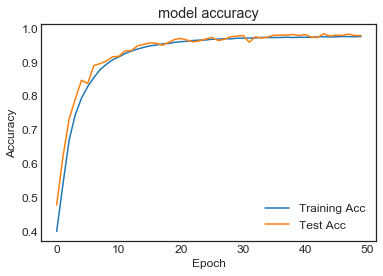

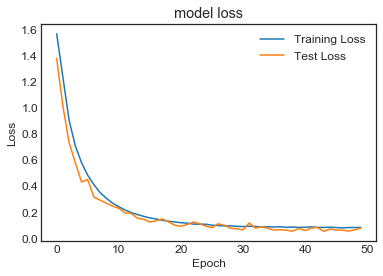

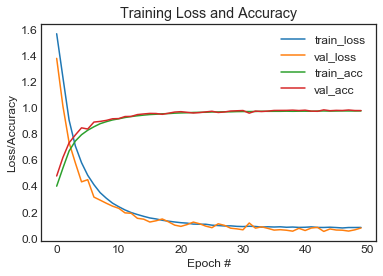

In [13]:
plt.rcParams.update({'font.size': 12})

import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='bottom right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

Validation Score:  0.0007593238287518034
Validation Accuracy:  1.0


C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

In [15]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=2)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

No of errors = 390/2602


Confusion Matrix
[[  65    2    3    1    2    1    0]
 [   3  122    9    2    0    3    0]
 [   2    1  256    0   14   11    0]
 [   0    0    2   28    0    0    0]
 [   1    0   21    2  272   16    0]
 [   8   19  108   15  135 1444    1]
 [   1    2    1    0    1    3   25]]


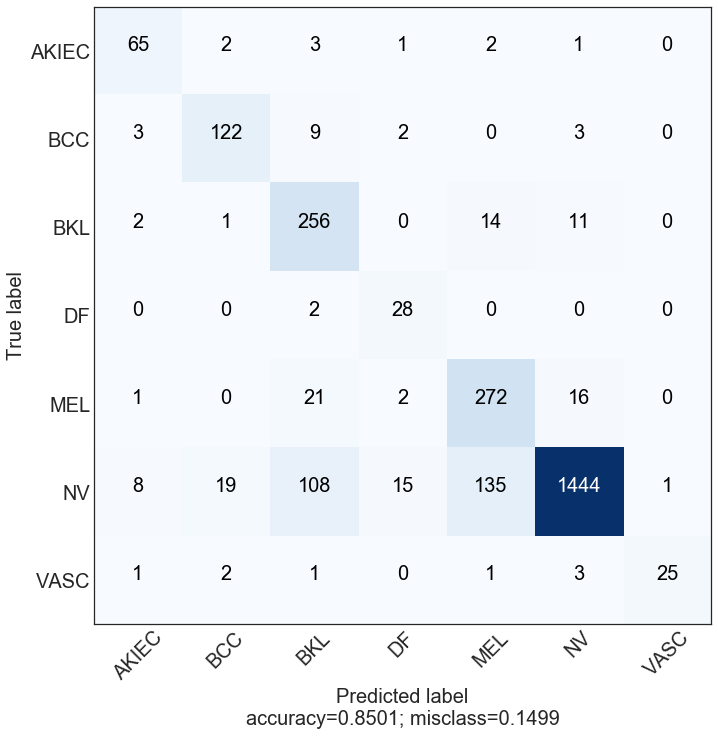

In [16]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[  65    2    3    1    2    1    0]
 [   3  122    9    2    0    3    0]
 [   2    1  256    0   14   11    0]
 [   0    0    2   28    0    0    0]
 [   1    0   21    2  272   16    0]
 [   8   19  108   15  135 1444    1]
 [   1    2    1    0    1    3   25]]
             precision    recall  f1-score   support

      AKIEC       0.81      0.88      0.84        74
        BCC       0.84      0.88      0.86       139
        BKL       0.64      0.90      0.75       284
         DF       0.58      0.93      0.72        30
        MEL       0.64      0.87      0.74       312
         NV       0.98      0.83      0.90      1730
       VASC       0.96      0.76      0.85        33

avg / total       0.88      0.85      0.86      2602



In [18]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9558823529411765
Specificity :  0.9838709677419355


_____